In [414]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))

import qiskit
provider = qiskit.IBMQ.load_account()


import numpy as np

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import NELDER_MEAD
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *
from matplotlib import pyplot as plt
%matplotlib inline


ibmqfactory.load_account:WARNING:2021-08-20 16:10:31,996: Credentials are already in use. The existing account in the session will be replaced.


In [140]:
quantum_instance = QuantumInstance(
                    backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                    shots=SHOTS)


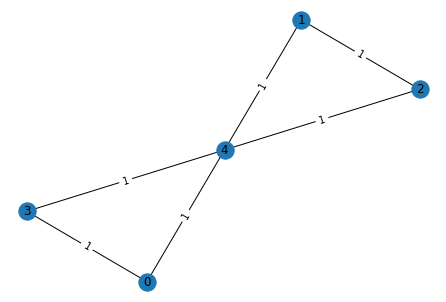

In [141]:
graph = generate_butterfly_graph(with_weights=False)
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

In [142]:
step_size = 0.1
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)


In [143]:
a_gamma, b_beta = np.meshgrid(a_gamma, b_beta)

In [144]:
def run_qaoa(gamma, beta):
    qaoa = QAOA(optimizer=COBYLA(maxiter=0),
                quantum_instance=quantum_instance,
                reps=1,
                initial_point=[gamma, beta])
    algorithm = MinimumEigenOptimizer(qaoa)
    result = algorithm.solve(max_cut_qubo)
    optimal_parameters = qaoa.optimal_params
    mean, distribution = max_cut.analyse(result)

    return mean

In [ ]:
F1 = np.zeros(a_gamma.shape)
for i in range(0, len(F1)):
    for j in range(0, len(F1)):
        # F1[i,j] = a_gamma[i][j] * b_beta[i][j]
        F1[i,j] = run_qaoa(a_gamma[i][j], b_beta[i][j])

In [185]:
from qiskit.opflow import (
    OperatorBase,
    ExpectationBase,
    ExpectationFactory,
    StateFn,
    CircuitStateFn,
    ListOp,
    I,
    CircuitSampler,
)
from time import time
from typing import Optional, List, Callable, Union, Dict, Tuple
class FixedQAOA(QAOA):

    def get_energy_evaluation(
        self,
        operator: OperatorBase,
        return_expectation: bool = False,
    ) -> Callable[[np.ndarray], Union[float, List[float]]]:
        """Returns a function handle to evaluates the energy at given parameters for the ansatz.

        This is the objective function to be passed to the optimizer that is used for evaluation.

        Args:
            operator: The operator whose energy to evaluate.
            return_expectation: If True, return the ``ExpectationBase`` expectation converter used
                in the construction of the expectation value. Useful e.g. to evaluate other
                operators with the same expectation value converter.


        Returns:
            Energy of the hamiltonian of each parameter, and, optionally, the expectation
            converter.

        Raises:
            RuntimeError: If the circuit is not parameterized (i.e. has 0 free parameters).

        """
        num_parameters = self.ansatz.num_parameters
        if num_parameters == 0:
            raise RuntimeError("The ansatz must be parameterized, but has 0 free parameters.")

        expect_op, expectation = self.construct_expectation(
            self._ansatz_params, operator, return_expectation=True
        )

        def energy_evaluation(parameters):
            #print(f"Parameters: {parameters}")
            parameter_sets = np.reshape(parameters, (-1, num_parameters))
            #print(f"Parameter set: {parameter_sets}")
            # Create dict associating each parameter with the lists of parameterization values for it
            param_bindings = dict(zip(self._ansatz_params, parameter_sets.transpose().tolist()))

            start_time = time()
            sampled_expect_op = self._circuit_sampler.convert(expect_op, params=param_bindings)
            means = np.real(sampled_expect_op.eval())

            if self._callback is not None:
                variance = np.real(expectation.compute_variance(sampled_expect_op))
                estimator_error = np.sqrt(variance / self.quantum_instance.run_config.shots)
                for i, param_set in enumerate(parameter_sets):
                    #print(f"param_set: {param_set}")
                    self._eval_count += 1
                    self._callback(self._eval_count, param_set, means[i], estimator_error[i])
            else:
                self._eval_count += len(means)

            end_time = time()

            return means if len(means) > 1 else means[0]

        if return_expectation:
            return energy_evaluation, expectation

        return energy_evaluation

In [270]:
counts = []
values = []
parameter_values = []
gammas = []
betas = []

In [385]:
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    #print(parameters)
    #if 0 <= parameters[0] <= 3.14 and 0 <= parameters[1] <= 3.14:
    gamma = parameters[0] % 3.14
    gammas.append(gamma)

    beta = parameters[1] % 3.14
    betas.append(beta)
    #parameter_values.append(parameters.copy())


In [456]:
counts = []
values = []
parameter_values = []
gammas = []
betas = []

qaoa = FixedQAOA(optimizer=COBYLA(maxiter=100),
            quantum_instance=quantum_instance,
            reps=1,
            initial_point=[1.3, 0.6],
            callback=store_intermediate_result
           )
algorithm = MinimumEigenOptimizer(qaoa)
result = algorithm.solve(max_cut_qubo)
mean, distribution = max_cut.analyse(result)
print(f"mean: {mean} ")
circuit = qaoa.get_optimal_circuit()
#circuit.draw()

mean: -3.9324999999999997 


In [454]:
print(values)
print(counts)
print(gammas)
print(betas)
#print(result.samples)

[-0.9072500000000001, 1.0430000000000001, 0.3227499999999999, 0.19500000000000006, -0.034750000000000045, -0.19575000000000004, -0.7937499999999998, -0.8722500000000001, -0.9097500000000002, -0.8902499999999999, -0.9069999999999999, -0.8912500000000001, -0.90875, -0.90125, -0.9042500000000001, -0.9000000000000001, -0.90525, -0.9035, -0.90975, -0.91025, -0.90925, -0.90025, -0.91075, -0.9092500000000003, -0.9062500000000001, -0.9125, -0.9115000000000001, -0.91125, -0.91, -0.9067500000000002, -0.91275, -0.90675]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
[1.3, 2.3, 1.3, 0.4541711767677774, 0.8770855883838887, 1.529393381717318, 1.2496336186865338, 1.181421414184555, 1.2838832378124794, 1.314076366072859, 1.2225896583181937, 1.3015599004363547, 1.2686071300051531, 1.2882089644325985, 1.2831358309462408, 1.285040759240192, 1.2857486421390858, 1.2805021538035875, 1.2853004488764874, 1.284555214386788, 1.285227190961

In [80]:
qaoa = QAOA(
    #operator=max_cut_qubo,
    optimizer=COBYLA(maxiter=0),
                quantum_instance=quantum_instance,
                reps=1,
                initial_point=[0, 0],
               
           )

In [97]:
op, offset = max_cut_qubo.to_ising()
circuit = qaoa.construct_circuit([0.1,1], operator=op)

In [82]:
circuit[0].draw()

┌───┐     ┌───┐┌──────────────────────┐     ┌───┐┌───┐»
q_0: ┤ H ├─────┤ X ├┤ Rz(1.00000000000000) ├─────┤ X ├┤ X ├»
     ├───┤┌───┐└─┬─┘├──────────────────────┤┌───┐└─┬─┘└─┬─┘»
q_1: ┤ H ├┤ X ├──┼──┤ Rz(1.00000000000000) ├┤ X ├──┼────┼──»
     ├───┤└─┬─┘  │  └──────────────────────┘└─┬─┘  │    │  »
q_2: ┤ H ├──■────┼────────────────────────────■────┼────┼──»
     ├───┤       │                                 │    │  »
q_3: ┤ H ├───────■─────────────────────────────────■────┼──»
     ├───┤                                              │  »
q_4: ┤ H ├──────────────────────────────────────────────■──»
     └───┘                                                 »
«     ┌──────────────────────┐┌───┐┌───────────────────────┐»
«q_0: ┤ Rz(1.00000000000000) ├┤ X ├┤ Rx(0.200000000000000) ├»
«     └──────────────────────┘└─┬─┘└─────────┬───┬─────────┘»
«q_1: ──────────────────────────┼────────────┤ X ├──────────»
«                               │            └─┬─┘          »
«q_2: ──────────────────────────┼──────────────┼────────────»
«                               │              │            »
«q_3: ──────────────────────────┼──────────────┼────────────»
«                               │              │            »
«q_4: ──────────────────────────■──────────────■────────────»
«                                                           »
«                                                           »
«q_0: ──────────────────────────────────────────────────────»
«     ┌──────────────────────┐┌───┐┌───────────────────────┐»
«q_1: ┤ Rz(1.00000000000000) ├┤ X ├┤ Rx(0.200000000000000) ├»
«     └──────────────────────┘└─┬─┘└─────────┬───┬─────────┘»
«q_2: ──────────────────────────┼────────────┤ X ├──────────»
«                               │            └─┬─┘          »
«q_3: ──────────────────────────┼──────────────┼────────────»
«                               │              │            »
«q_4: ──────────────────────────■──────────────■────────────»
«                                                           »
«                                                           »
«q_0: ──────────────────────────────────────────────────────»
«                                                           »
«q_1: ──────────────────────────────────────────────────────»
«     ┌──────────────────────┐┌───┐┌───────────────────────┐»
«q_2: ┤ Rz(1.00000000000000) ├┤ X ├┤ Rx(0.200000000000000) ├»
«     └──────────────────────┘└─┬─┘└─────────┬───┬─────────┘»
«q_3: ──────────────────────────┼────────────┤ X ├──────────»
«                               │            └─┬─┘          »
«q_4: ──────────────────────────■──────────────■────────────»
«                                                           »
«                                                           
«q_0: ──────────────────────────────────────────────────────
«                                                           
«q_1: ──────────────────────────────────────────────────────
«                                                           
«q_2: ──────────────────────────────────────────────────────
«     ┌──────────────────────┐┌───┐┌───────────────────────┐
«q_3: ┤ Rz(1.00000000000000) ├┤ X ├┤ Rx(0.200000000000000) ├
«     └──────────────────────┘└─┬─┘├───────────────────────┤
«q_4: ──────────────────────────■──┤ Rx(0.200000000000000) ├
«                                  └───────────────────────┘

In [83]:
circuit[0].measure_all()

In [84]:
job = qiskit.execute([circuit[0], circuit[0]], backend=provider.get_backend('ibmq_qasm_simulator'),shots=8000)

In [85]:
job.update_name("Test_ibmq_multiple_circuits")

'Test_ibmq_multiple_circuits'

In [61]:
counts = job.result().get_counts()

In [63]:
p = qaoa.get_probabilities_for_counts(counts)
p

array([0.055875, 0.037375, 0.04075 , 0.020375, 0.042125, 0.022625,
       0.045625, 0.016875, 0.04175 , 0.042375, 0.019875, 0.022   ,
       0.020125, 0.01975 , 0.016375, 0.03725 , 0.037   , 0.01675 ,
       0.019125, 0.02025 , 0.020875, 0.01925 , 0.042375, 0.041875,
       0.020375, 0.04425 , 0.0175  , 0.037   , 0.021125, 0.039375,
       0.04125 , 0.0605  ])

In [64]:
sum(p)

1.0

In [72]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [66]:
compute_expectation(counts, graph)

-2.74175

In [73]:
def create_cirucit(gamma,beta):
    circuits = qaoa.construct_circuit([gamma,beta], operator=op)
    circuit = circuits[0]
    circuit.measure_all()
    return circuit

In [98]:
F1 = np.zeros(a_gamma.shape)
for i in range(0, len(F1)):
    circuits = []
    for j in range(0, len(F1)):
        circuit = create_cirucit(a_gamma[i][j], b_beta[i][j])
        circuits.append(circuit)
    
    job = qiskit.execute(circuits, backend=provider.get_backend('ibmq_qasm_simulator'),shots=8000)
    job.update_name(f"Butterfly_no_weights_Row_{i}")
    print(f"Butterfly_no_weights_Row_{i}_test_2")
    j = 0
    for count in job.result().get_counts():
        mean = compute_expectation(count, graph)
        F1[i,j] = mean
        j += 1

Butterfly_no_weights_Row_0_test_2
Butterfly_no_weights_Row_1_test_2
Butterfly_no_weights_Row_2_test_2
Butterfly_no_weights_Row_3_test_2
Butterfly_no_weights_Row_4_test_2
Butterfly_no_weights_Row_5_test_2
Butterfly_no_weights_Row_6_test_2
Butterfly_no_weights_Row_7_test_2
Butterfly_no_weights_Row_8_test_2
Butterfly_no_weights_Row_9_test_2
Butterfly_no_weights_Row_10_test_2
Butterfly_no_weights_Row_11_test_2
Butterfly_no_weights_Row_12_test_2
Butterfly_no_weights_Row_13_test_2
Butterfly_no_weights_Row_14_test_2
Butterfly_no_weights_Row_15_test_2
Butterfly_no_weights_Row_16_test_2
Butterfly_no_weights_Row_17_test_2
Butterfly_no_weights_Row_18_test_2
Butterfly_no_weights_Row_19_test_2
Butterfly_no_weights_Row_20_test_2
Butterfly_no_weights_Row_21_test_2
Butterfly_no_weights_Row_22_test_2
Butterfly_no_weights_Row_23_test_2
Butterfly_no_weights_Row_24_test_2
Butterfly_no_weights_Row_25_test_2
Butterfly_no_weights_Row_26_test_2
Butterfly_no_weights_Row_27_test_2
Butterfly_no_weights_Row_28_te

[[-2.9775  -3.00625 -2.996   ... -3.005   -2.997   -3.00075]
 [-3.00125 -2.92325 -2.8895  ... -3.0935  -3.06325 -3.0255 ]
 [-2.9995  -2.89375 -2.763   ... -3.20475 -3.16175 -3.069  ]
 ...
 [-3.013   -3.14275 -3.21825 ... -2.684   -2.8035  -2.941  ]
 [-3.01325 -3.081   -3.12925 ... -2.818   -2.854   -2.95275]
 [-2.9845  -3.026   -3.0555  ... -2.944   -2.9675  -2.978  ]]


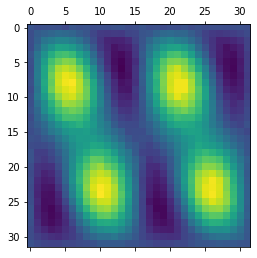

In [213]:
print(F1)
plt.matshow(F1)
plt.show()

In [100]:
np.mean(F1)

-2.7280107421875

In [101]:
np.unravel_index(np.argmin(F1), F1.shape)

(6, 13)

In [102]:
np.min(F1)

-3.3895

In [103]:
np.max(F1)

-1.77725

In [104]:
with open('landscape_butterfly_no_weights_ibmq_qasm_simulator_results.npy', 'wb') as f:
    np.save(f, F1)

In [105]:
with open('landscape_butterfly_no_weights_ibmq_qasm_simulator_results.npy', 'rb') as f:
    f2 = np.load(f)

In [106]:
np.max(f2)

-1.77725

In [214]:
import plotly.graph_objects as go


In [427]:
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)
fig = go.Figure(data=go.Surface(z=F1, x=a_gamma, y=b_beta))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))


fig.update_layout(title="QAOA MaxCut", scene=dict(
xaxis_title="gamma",
    yaxis_title="beta",
    zaxis_title="mean"
))

In [444]:
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)
fig = go.Figure(data=go.Heatmap(z=F1, x=b_beta, y=a_gamma,   type = 'heatmap',
   colorscale = 'viridis'))
fig.update_layout(title="QAOA MaxCut", width=700, height=700,
xaxis_title="beta",
    yaxis_title="gamma")

In [445]:
fig.add_trace(
    go.Scatter(mode="lines", x=gammas, y=betas, marker_symbol=[200],
                   marker_color="white", 
                   marker_line_width=1, marker_size=8))

y, x = np.unravel_index(np.argmin(F1), F1.shape)

fig.add_trace(
    go.Scatter(mode="markers", x=[x*step_size], y=[y*step_size], marker_symbol=[204],
                   marker_color="red", 
                   marker_line_width=1, marker_size=16))

fig.add_trace(
    go.Scatter(mode="markers", x=[gammas[0]], y=[betas[0]], marker_symbol=[204],
                   marker_color="gray", 
                   marker_line_width=1, marker_size=16))

fig.add_trace(
    go.Scatter(mode="markers", x=[gammas[-1]], y=[betas[-1]], marker_symbol=[204],
                   marker_color="green", 
                   marker_line_width=1, marker_size=16))




In [441]:
fig = go.Figure(data=go.Scatter(x=counts, y=values))
fig.update_layout(xaxis_title="Evaluation Counts", yaxis_title="Evaluated Mean", title="Optimizer")
fig.show()